<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/LongShortCointegra%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance -qU --no-cache-dir
import yfinance as yf

import numpy as np
import pandas as pd

import seaborn
from seaborn.matrix import axis_ticklabels_overlap
import matplotlib.pyplot as plt
from pylab import rcParams

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import coint, adfuller

In [2]:
#rcParams['figure.figsize'] = 15, 5

def check_estacionaridade(X, cutoff=0.01):
    # H_0 é nao-estacionário, i.e., admite raiz unitaria (teste adfuller)
    
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' A serie "'+X.name+'" é, provavelmente, estacionaria.')
        return True
    else:
        print('p-value = ' + str(pvalue) + ' A serie "'+X.name+'" é, provavelmente, não-estacionaria.')
        return False

def zscore(series):
    return (series - series.mean()) / np.std(series)

def find_cointegrated_pairs(data,cutoff=0.1):
  n = data.shape[1]
  score_matrix = np.zeros((n, n))
  pvalue_matrix = np.ones((n, n))
  keys = data.keys()
  pairs = []
  for i in range(n):
      for j in range(i+1, n):
          X = data[keys[i]]
          Y = data[keys[j]]
          result = coint(X, Y)
          score = result[0]
          pvalue = result[1]
          score_matrix[i, j] = score
          pvalue_matrix[i, j] = pvalue
          if pvalue < cutoff:
              pairs.append((keys[i], keys[j]))
  return score_matrix, pvalue_matrix, pairs    

def residuos (x,y)  :
  # slope,intercept, r, pvalue, stderr = stats.linregress(y=y,x=x)
  from scipy import stats
  return y - stats.linregress(y=y,x=x)[0] * x


def arrange_subplots(xs, ys, n_plots , tt =[]):
  """
  ---- Parameters ----
  xs (n_plots, d): list with n_plot different lists of x values that we wish to plot
  ys (n_plots, d): list with n_plot different lists of y values that we wish to plot
  n_plots (int): the number of desired subplots
  """
  from matplotlib import gridspec
  %matplotlib inline

  # compute the number of rows and columns
  if n_plots<3 : 
    n_cols = 3
    n_rows = 1
  else: 
    n_cols = int(np.sqrt(n_plots))
    n_rows = int(np.ceil(n_plots / n_cols))

  # setup the plot
  gs = gridspec.GridSpec(n_rows, n_cols)
  scale = max(n_cols, n_rows)
  fig = plt.figure(figsize=(.5 * scale, .5 * scale))

  # loop through each subplot and plot values there
  for i in range(n_plots):
    ax = fig.add_subplot(gs[i])
    ax.title.set_text(tt[i])
    ax.plot(xs[i], ys[i])
    plt.axhline(y = 0, color = 'silver', linestyle = '-')
    plt.axhline(y = 1, color = 'orange', linestyle = '-')
    plt.axhline(y = -1, color = 'orange', linestyle = '-')
    plt.axhline(y = 2, color = 'red', linestyle = '-')
    plt.axhline(y = -2, color = 'red', linestyle = '-')

    plt.show()

#############################################################################################################
symbols = [
    'RRRP3', 'ENEV3','PETR3', 'PETR4', 'PRIO3',
    'ABEV3', 'ASAI3','CRFB3','LREN3', 'MGLU3','PCAR3', 'VIIA3',
    'AZUL4', 'GOLL4', 'CVCB3',
    'B3SA3', 'BPAN4','BPAC11', 'BBSE3','BBDC3', 'BBDC4', 'BBAS3', 'CIEL3','ITSA4','ITUB4', 'SANB11',
    'BRML3', 'IGTI11','MULT3',
    'BRAP4', 'CMIN3', 'GGBR4', 'GOAU4','CSNA3','USIM5','VALE3',
    'BRFS3', 'JBSS3', 'MRFG3', 'BEEF3',
    'CCRO3', 'ECOR3',
    'CMIG4', 'CPLE6', 'CPFE3', 'ELET3', 'ELET6','ENBR3', 'ENGI11','EGIE3', 'EQTL3','TAEE11',
    'CYRE3', 'DXCO3', 'EZTC3','JHSF3','MRVE3',
    'HAPV3', 'HYPE3', 'QUAL3', 'RADL3', 'RDOR3',
    'LWSA3', 'POSI3', 'TOTS3','SQIA3' , 'VLID3' ,
    'UGPA3', 'VBBR3', 
    'BOVA11'
    ] 

In [3]:
N=int(len(symbols)*(len(symbols)-1)/2)
N

2415

In [4]:
relative_cutoff = 1 * 10 ** (-int(np.log(N)/np.log(10))-1)
relative_cutoff

0.0001

In [5]:
dados = yf.download((pd.Series(symbols)+'.SA').to_list(), period = '1y', auto_adjust=True , progress = False)['Close']
dados.dropna(inplace=True)
dados.shape[0]

235

In [6]:
scores, pvalues, pairs = find_cointegrated_pairs(dados,relative_cutoff)

In [7]:
pairs

[('BPAN4.SA', 'VBBR3.SA'), ('IGTI11.SA', 'SQIA3.SA')]

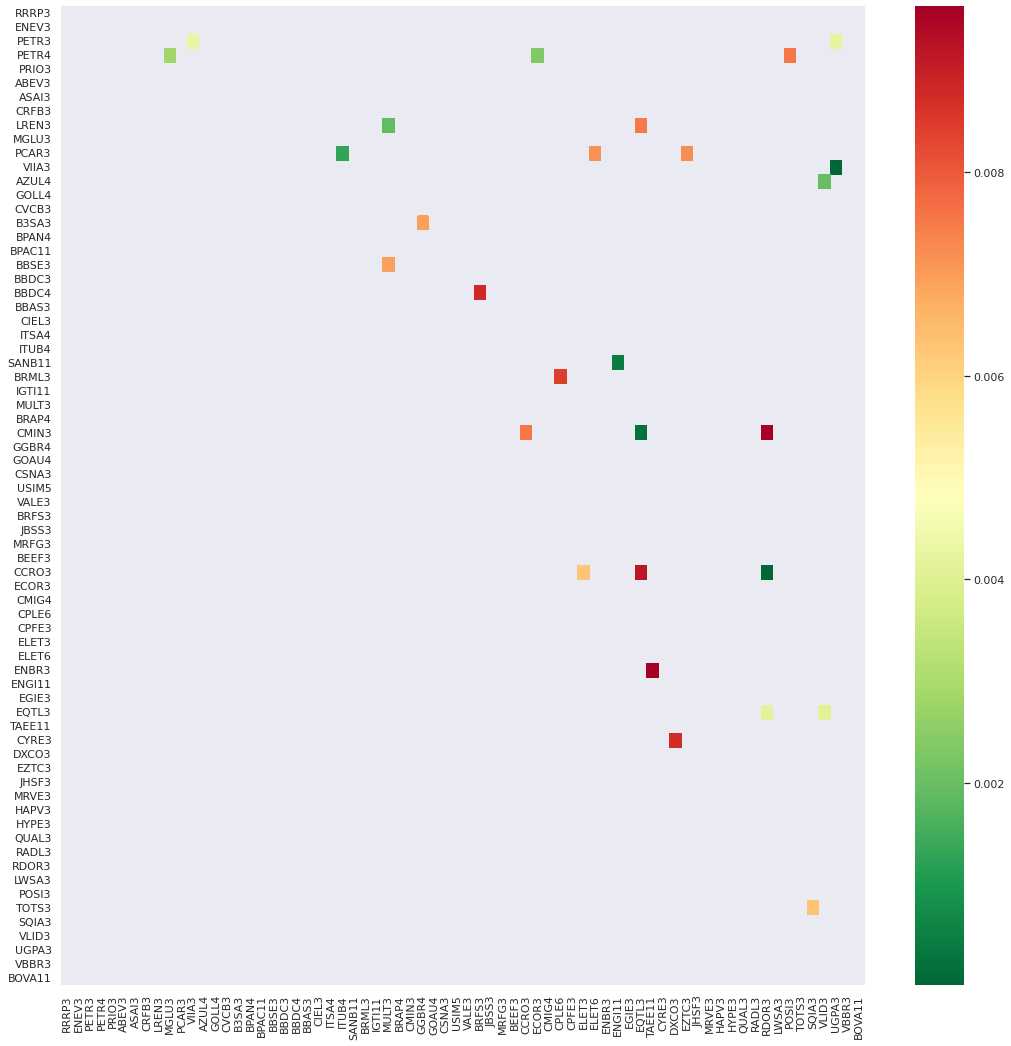

In [8]:
seaborn.set(rc={'figure.figsize':(18,18)})
seaborn.heatmap(
    pvalues, 
    xticklabels=symbols, 
    yticklabels=symbols, 
    cmap='RdYlGn_r', 
    mask = (pvalues >= 0.01)
)

In [9]:
!pip install -qU kaleido
import kaleido
import plotly
plotly.io.renderers.default = 'png'


In [10]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


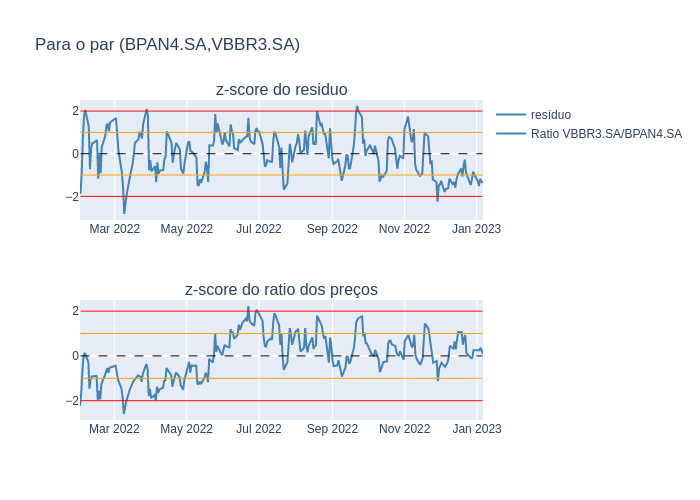

In [11]:
Y = dados[pairs[0][1]]
X = dados[pairs[0][0]]

trace1 = go.Scatter( x = X.index,  y = zscore(residuos(x=X,y=Y)) , 
                    name = 'resíduo',
                    line=dict(color='steelblue'))

trace2 = go.Scatter( x = Y.index,  y = zscore(Y/X) , 
                    name = 'Ratio '+Y.name+'/'+X.name,
                    line=dict(color='steelblue'))

fig = make_subplots(rows=2, cols=1,subplot_titles=(['z-score do residuo','z-score do ratio dos preços']))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(shapes=[{'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}}
                             ],title='Para o par ('+X.name+','+Y.name+')')
fig.show()

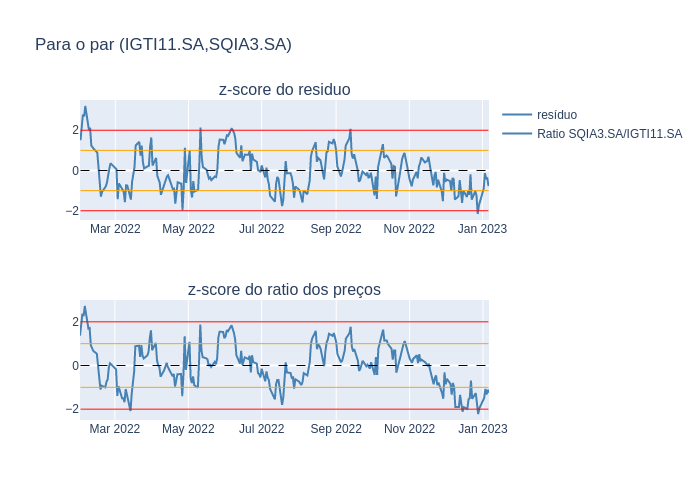

In [12]:
Y = dados[pairs[1][1]]
X = dados[pairs[1][0]]

trace1 = go.Scatter( x = X.index,  y = zscore(residuos(x=X,y=Y)) , 
                    name = 'resíduo',
                    line=dict(color='steelblue'))

trace2 = go.Scatter( x = Y.index,  y = zscore(Y/X) , 
                    name = 'Ratio '+Y.name+'/'+X.name,
                    line=dict(color='steelblue'))

fig = make_subplots(rows=2, cols=1,subplot_titles=(['z-score do residuo','z-score do ratio dos preços']))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(shapes=[{'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y1','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':0,'y1': 0,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'black','width': 1,'dash':'dash'}},
                             {'type': 'line','y0':1,'y1': 1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':-1,'y1': -1,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'orange','width': 1}},
                             {'type': 'line','y0':2,'y1': 2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}},
                             {'type': 'line','y0':-2,'y1': -2,'x0':min(X.index),'x1':max(X.index),
                              'yref':'y2','line': {'color': 'red','width': 1}}
                             ],title='Para o par ('+X.name+','+Y.name+')')
fig.show()

In [13]:
print(X.name,Y.name)

IGTI11.SA SQIA3.SA


In [14]:
trades = pd.concat([zscore(residuos(x=X,y=Y)), residuos(x=X,y=Y)], axis=1)
trades.columns = ["sinal", "posicao"]

trades["acao"] = 0.0
trades.loc[trades.sinal <= -1, "acao"] = 1  # compra par
trades.loc[trades.sinal >= 1, "acao"] = -1  # vende par
trades

,sinal,posicao,acao
Date,,,
2022-01-31 00:00:00-03:00,1.503635,-3.979450,-1.0
2022-02-01 00:00:00-03:00,2.357783,-3.263776,-1.0
2022-02-02 00:00:00-03:00,2.775627,-2.913671,-1.0
2022-02-03 00:00:00-03:00,2.687347,-2.987639,-1.0
2022-02-04 00:00:00-03:00,3.203450,-2.555206,-1.0
...,...,...,...
2023-01-02 00:00:00-03:00,-0.903879,-5.996663,0.0
2023-01-03 00:00:00-03:00,-0.134174,-5.351741,0.0
2023-01-04 00:00:00-03:00,-0.395277,-5.570514,0.0


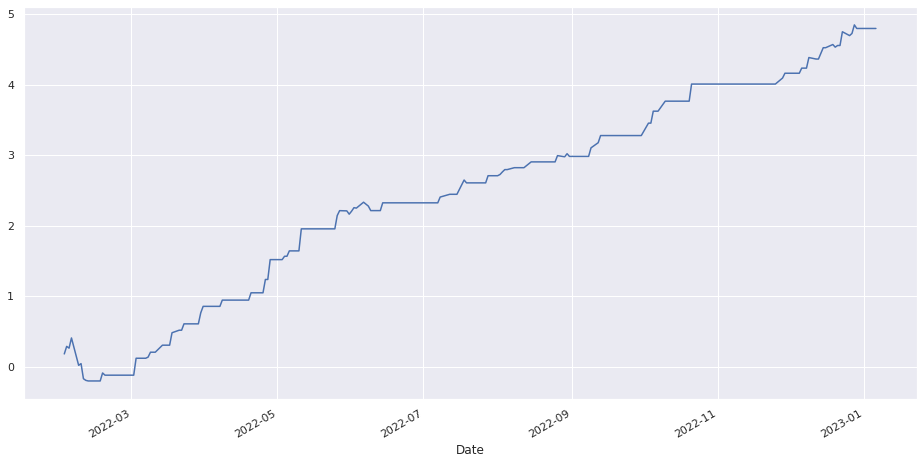

In [15]:
retornos = trades.posicao.pct_change() * trades.acao
retornos.cumsum().plot(figsize=(16,8))